# Introduction
---
This notebook shows how to generate a time series of Sentinel-1 imagery for a given time period over a specific region of interest (ROI). It demonstrates the use of the _sentinelAPI_ from _sentinelsat_ to search for Sentinel-1 (S1) data, and how to access the corresponding _netcdf_ files of all found images. HH and HV channles are are calibrated and stacked to false-color RGB images for visualization in the original radar geometry and on a georeferenced map. The processing steps are first shown and tested on one example image, then a loop over the time series over the S1 search results produces a time series pngs.

For every S1 scene, another search is performed to find overlapping Sentinel-2 (S2) data. Search results are written to text files for later download and processing. One example for common visualiztion of overlapping S1 and S2 data is shown.


## Requirements
---
Required packages are listed in "provision.sh".

## Import libraries
---
Import required libraries:

In [1]:
import sys
import linecache
from os import environ
from dotenv import load_dotenv
from loguru import logger
from pathlib import Path

import datetime
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from dateparser import parse

import xarray as xr
import numpy as np

import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


## Set loglevel for logger output
---
Set the loglevel to _ERROR_, _WARNING_, _INFO_, or _DEBUG_ to control information output to screen:

In [2]:
loglevel = 'INFO'
logger.remove()
logger.add(sys.stderr, level=loglevel)

1

## Enable copernicus scihub access
---
Use of the _sentinelAPI_ requires an account at _https://scihub.copernicus.eu/dhus/_. You can avoid hardcoding your scihub username and password in this notebook by using environment variables. To do this, create a file called _".env"_ with the following lines in the same folder as this notebook:

>DHUS_USER="your-scihub-username"  
>DHUS_PASSWORD="your-scihub-password"

The code below automatically sets the environment variables defined in your _".env"_ file and loads them into python variables.

__NB:__ Add the ".env" file to your ".gitignore" to avoid publishing it in your git repository!

In [3]:
load_dotenv()

USERNAME = environ.get('DHUS_USER')
PASSWORD = environ.get('DHUS_PASSWORD')

# check that this was successful
if USERNAME == None:
    logger.error('USERNAME is: "None". Set variables correctly in ".env" file.')
if PASSWORD == None:
    logger.error('PASSWORD is: "None". Set variables correctly in ".env" file.')

## Set S1 search parameters
---
Set the search parameters for your _sentinelAPI_ query. The ROI is defined as a polygon in geojson format. The _area_relation_ should be chosen depending on the size of your ROI and the specific needs of your project. For example, choose _Contains_ for a small ROI to ensure that the entire area is covered, or choose _Intersects_ for large ROIs to include all imagery that covers only parts of the area.

In [4]:
# geojson file with ROI polygon
json_file = 'belgica_bank_ROI_small.geojson'

# set ROI from json file
ROI = geojson_to_wkt(read_geojson(json_file))

# cover the full polygon?
##area_relation = 'Intersects'
area_relation = 'Contains'

# time interval
starttime = parse('2022-04-01T00:00:00', settings={"DATE_ORDER": "YMD"})
endtime   = parse('2022-04-20T23:59:59', settings={"DATE_ORDER": "YMD"})

logger.debug(f'json_file:     {json_file}')
logger.debug(f'starttime:     {starttime}')
logger.debug(f'endtime:       {endtime}')
logger.debug(f'area_relatipn: {area_relation}')

## Create sentinelAPI and search for S1 data
---
Perform the _sentinelAPI_ query. This will search in the external _copernicus.scihub_ data base, results will be listed in _S1_result_dict_:

In [5]:
# create Sentinel API
Sentinelapi = SentinelAPI(USERNAME, PASSWORD)

# search for S1 data
S1_result_dict = Sentinelapi.query(
    area = ROI,
    date = (starttime,endtime),
    area_relation = area_relation,
    platformname = "Sentinel-1",
    producttype = "GRD"
)

## Inspect search results
---
Get some basic information about your search results. Download of the _SAFE_ folders from copernicus.scihub to this platform is slow and usually crashes at the time of writing this notebook. You can access the data in _netcdf_ format from the met server (see below), or you can download the _SAFE_ format later on a different PC. For this purpose, all S1 scenes are written to a text file (_search_result_file_), which can be used to build download URLS for example from creodias.

In [6]:
# get number of hits
n_imgs = len(S1_result_dict.keys())
logger.info(f'Found {n_imgs} Sentinel-1 images')

# initialize list of found images
img_list = []

# loop over search results, print to screen, and append to img_list
for i,key in enumerate(S1_result_dict.keys()):
    logger.info(f"Image {i+1}/{n_imgs}: {S1_result_dict[key]['title']}")
    img_list.append(S1_result_dict[key]['title'])

# write search result S1 name strings to txt file
search_result_dir = Path('search_results')
search_result_dir.mkdir(exist_ok=True)
search_result_file = search_result_dir / f'{json_file.split(".")[0]}_S1_search_results.txt'

logger.debug(f'search_result_dir: {search_result_dir}')
logger.debug(f'search_result_file: {search_result_file}')

with open(search_result_file, 'w') as f:
    f.write('\n'.join(img_list))

2023-02-09 13:02:32.401 | INFO     | __main__:<module>:3 - Found 13 Sentinel-1 images
2023-02-09 13:02:32.403 | INFO     | __main__:<module>:10 - Image 1/13: S1A_EW_GRDM_1SDH_20220420T074526_20220420T074631_042854_051D7C_BA0C
2023-02-09 13:02:32.404 | INFO     | __main__:<module>:10 - Image 2/13: S1A_EW_GRDM_1SDH_20220418T080146_20220418T080250_042825_051C82_6C8D
2023-02-09 13:02:32.405 | INFO     | __main__:<module>:10 - Image 3/13: S1A_EW_GRDM_1SDH_20220416T081809_20220416T081913_042796_051BA3_D51C
2023-02-09 13:02:32.405 | INFO     | __main__:<module>:10 - Image 4/13: S1A_EW_GRDM_1SDH_20220415T073723_20220415T073828_042781_051B13_BEA7
2023-02-09 13:02:32.406 | INFO     | __main__:<module>:10 - Image 5/13: S1A_EW_GRDM_1SDH_20220409T082620_20220409T082724_042694_051832_4E37
2023-02-09 13:02:32.407 | INFO     | __main__:<module>:10 - Image 6/13: S1A_EW_GRDM_1SDH_20220413T075349_20220413T075454_042752_051A16_B52A
2023-02-09 13:02:32.408 | INFO     | __main__:<module>:10 - Image 7/13: S1

## Test data access, processing, and visualization
---
Test the processing on the first hit before looping over all search results:

In [7]:
# select first hit
S1_base = S1_result_dict[list(S1_result_dict.keys())[0]]['title']

## Build data URL
---
Use the S1 name string to build the correct path to the location of the _netcdf_ data on the met server:

In [8]:
# get date info from S1 name string
S1_year  = S1_base.split('_')[4][0:4]
S1_month = S1_base.split('_')[4][4:6]
S1_day   = S1_base.split('_')[4][6:8]

# get S1 mode and sensor
S1_sensor = S1_base[0:3]
S1_mode   = S1_base.split('_')[1]

# build url and open data set
S1_url = f'https://nbstds.met.no/thredds/dodsC/NBS/{S1_sensor}/{S1_year}/{S1_month}/{S1_day}/{S1_mode}/{S1_base}.nc'
logger.debug(f'S1_url: {S1_url}')
S1_dst = xr.open_dataset(S1_url)

## Load required data
---
Load HH and HV amplitude and calibration lookup table. Also load lat/lon bands and find extent of the image. The connection to the server with the netcdf data is slow, so for a first visualization, you may not want to load to entire image. 

In [9]:
# connection to the server is very slow
# => sub-step when loading data set
stride = 25

# HH
DN_HH  = S1_dst["Amplitude_HH"][0,::stride,::stride]
LUT_HH = S1_dst["sigmaNought_HH"][0,::stride,::stride]

# HV
DN_HV  = S1_dst["Amplitude_HV"][0,::stride,::stride]
LUT_HV = S1_dst["sigmaNought_HV"][0,::stride,::stride]

# lat/lon
lon = S1_dst['lon'][::stride,::stride]
lat = S1_dst['lat'][::stride,::stride]

# get image footprint
lon_min_geo = np.min(lon)
lon_max_geo = np.max(lon)
lat_min_geo = np.min(lat)
lat_max_geo = np.max(lat)

# this is faster, but not all S1 netcdf products have these attributes
##lon_min_geo = S1_dst.attrs['geospatial_lon_min']
##lat_min_geo = S1_dst.attrs['geospatial_lat_min']
##lon_max_geo = S1_dst.attrs['geospatial_lon_max']
##lat_max_geo = S1_dst.attrs['geospatial_lat_max']

logger.debug(f'lon_min: {lon_min_geo}')
logger.debug(f'lon_max: {lon_max_geo}')
logger.debug(f'lat_min: {lat_min_geo}')
logger.debug(f'lat_max: {lat_max_geo}')

## Calibrate HH and HV
---
Use the LUT to calibrate HH and HV channels to sigma0 and convert to dB. You can also add the noise coorection at this point. Calibration and noise correction are described here: _https://sentinels.copernicus.eu/web/sentinel/radiometric-calibration-of-level-1-products_

In [10]:
# calibrate HH and HV channel and convert to dB
sigma0_HH    = (DN_HH**2) / (LUT_HH**2)
sigma0_HV    = (DN_HV**2) / (LUT_HV**2)
sigma0_HH_dB = 10 * np.log10(sigma0_HH)
sigma0_HV_dB = 10 * np.log10(sigma0_HV)

## Find min/max percentiles
---
For better visualization, you may want to adjust the dynamic range of _imshow_ or _pcolormesh_. You can hardcode _vmin_ and _vmax_ values to make the color or grayscale of different images comparable, or you use flexible _vmin_ and _vmax_ values based on the percentiles of the data:

In [11]:
# find min/max percentiles for good visualization
vmin_HH = np.nanpercentile(sigma0_HH_dB, 0.5)
vmax_HH = np.nanpercentile(sigma0_HH_dB, 99.5)
vmin_HV = np.nanpercentile(sigma0_HV_dB, 0.5)
vmax_HV = np.nanpercentile(sigma0_HV_dB, 99.5)

logger.info(f'vmin_HH: {vmin_HH}')
logger.info(f'vmax_HH: {vmax_HH}')
logger.info(f'vmin_HV: {vmin_HV}')
logger.info(f'vmax_HV: {vmax_HV}')

2023-02-09 13:03:39.091 | INFO     | __main__:<module>:7 - vmin_HH: -22.238682746887207
2023-02-09 13:03:39.092 | INFO     | __main__:<module>:8 - vmax_HH: 0.9825751662254357
2023-02-09 13:03:39.093 | INFO     | __main__:<module>:9 - vmin_HV: -31.915431213378906
2023-02-09 13:03:39.094 | INFO     | __main__:<module>:10 - vmax_HV: -16.51040706634521


## Stack to false-color RGB
---
Use the _vmin/vmax_ percentiles to normalize (scale) the individual channels and stack them to a false-color RGB image. A commonly used combination of channels for dual-pol data is for example red: HV, green: HH, blue: HH.

In [12]:
# create 8-bit false_color RGB
new_min = 0
new_max = 255

# linear map from sigma0 in dB to new_min and new_max
HH_scaled = (sigma0_HH_dB - (vmin_HH)) * ((new_max - new_min) / ((vmax_HH) - (vmin_HH))) + new_min
HV_scaled = (sigma0_HV_dB - (vmin_HV)) * ((new_max - new_min) / ((vmax_HV) - (vmin_HV))) + new_min

# clip values
HH_scaled = np.clip(HH_scaled, new_min, new_max)
HV_scaled = np.clip(HV_scaled, new_min, new_max)

# stack scaled channels to fals-color RGB
RGB = np.stack((HV_scaled,HH_scaled,HH_scaled),2)

## Visualize in radar geometry
---
Visualize the calibrated data (HH and HV as individual grayscale and combined as false-color RGB) for a first visual check. Images are displayed in the radar geometry (azimuth-x-range):

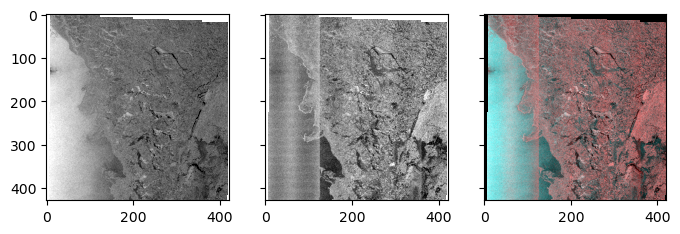

In [13]:
# visualize in radar geometry
fig, axes = plt.subplots(1,3,figsize=(8,4),sharex=True,sharey=True)
axes = axes.ravel()
axes[0].imshow(sigma0_HH_dB, cmap='gray', vmin=vmin_HH, vmax=vmax_HH)
axes[1].imshow(sigma0_HV_dB, cmap='gray', vmin=vmin_HV, vmax=vmax_HV)
axes[2].imshow(RGB/255)

## Visualize georeferenced on map
---
Visualize the data on a map. You will need to define map projections suitable for your area of interest and project. Minimum and maximum map extent are set based on the min/max of the image lat/lon values:

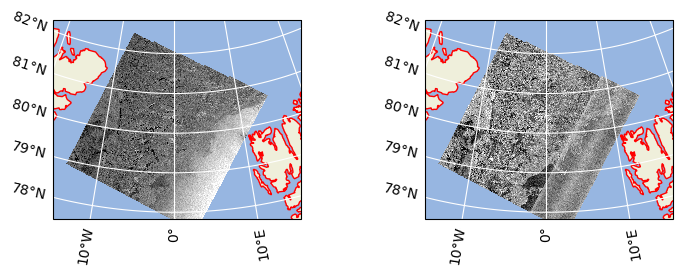

In [14]:
orig_projection = ccrs.PlateCarree()
target_projection = ccrs.Stereographic(central_longitude=0,central_latitude=60.)

fig, axes = plt.subplots(1,2, figsize=(8,3), subplot_kw={'projection': target_projection},sharex=True,sharey=True)
axes = axes.ravel()

axes[0].set_extent([lon_min_geo,lon_max_geo, lat_min_geo, lat_max_geo])
axes[0].add_feature(cartopy.feature.LAND)
axes[0].add_feature(cartopy.feature.OCEAN)
gl0 = axes[0].gridlines(color='white',draw_labels=True, y_inline=False)
axes[0].coastlines(color='red',resolution='10m')
axes[0].pcolormesh(lon, lat, sigma0_HH_dB, transform=orig_projection, cmap='gray', vmin=vmin_HH, vmax=vmax_HH)
gl0.top_labels = False
gl0.right_labels = False

axes[1].set_extent([lon_min_geo,lon_max_geo, lat_min_geo, lat_max_geo])
axes[1].add_feature(cartopy.feature.LAND)
axes[1].add_feature(cartopy.feature.OCEAN)
gl1 = axes[1].gridlines(color='white',draw_labels=True, y_inline=False)
axes[1].coastlines(color='red',resolution='10m')
axes[1].pcolormesh(lon, lat, sigma0_HV_dB, transform=orig_projection, cmap='gray', vmin=vmin_HV, vmax=vmax_HV)
gl1.top_labels = False
gl1.right_labels = False

plt.subplots_adjust(left = None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)

## Set parameters for loop over all S1 images
---
Before you loop multiple S1 images to create a time series of figures, you should consider the map extent. You can keep the map extent flexible, adjusted to the footprint of the individual images. However, if you intend to make a gif or animation of your images, you should fix the image extent. Use the example figures above to define the fixed map extent for your specific study. Depending on your chosen map extent, you can also adjust the locations of your gridlines.

__NB:__ Below, you can also define the sub-step for loading the data again (_stride_). If you are looping over many images, be aware that the processing will take a long time because of slow data access. Choose your _stride_ wisely.

In [15]:
# define fixed map extent for time series
lon_min_geo_fixed = -15
lon_max_geo_fixed = 0
lat_min_geo_fixed = 78.5
lat_max_geo_fixed = 81

# define vectors for gridlines
x_grid = [-15, -10, -5]
y_grid = [79, 80]

# connection to the server is very slow
# => sub-step when loading data set
stride = 20

## Loop over all S1 imagery
---
Loop over all prviously found S1 images, load and calibrate the data, and display on a map.

2023-02-09 13:05:31.917 | INFO     | __main__:<module>:3 - Processing S1 image 1/13
2023-02-09 13:05:31.918 | INFO     | __main__:<module>:21 - S1_url: https://nbstds.met.no/thredds/dodsC/NBS/S1A/2022/04/20/EW/S1A_EW_GRDM_1SDH_20220420T074526_20220420T074631_042854_051D7C_BA0C.nc
2023-02-09 13:05:32.499 | INFO     | __main__:<module>:35 - Calibrating HH and HV
2023-02-09 13:06:29.893 | INFO     | __main__:<module>:61 - Drawing and saving figure
2023-02-09 13:06:42.535 | INFO     | __main__:<module>:3 - Processing S1 image 2/13
2023-02-09 13:06:42.536 | INFO     | __main__:<module>:21 - S1_url: https://nbstds.met.no/thredds/dodsC/NBS/S1A/2022/04/18/EW/S1A_EW_GRDM_1SDH_20220418T080146_20220418T080250_042825_051C82_6C8D.nc
2023-02-09 13:06:43.198 | INFO     | __main__:<module>:35 - Calibrating HH and HV
2023-02-09 13:07:48.312 | INFO     | __main__:<module>:61 - Drawing and saving figure
2023-02-09 13:08:00.729 | INFO     | __main__:<module>:3 - Processing S1 image 3/13
2023-02-09 13:08:0

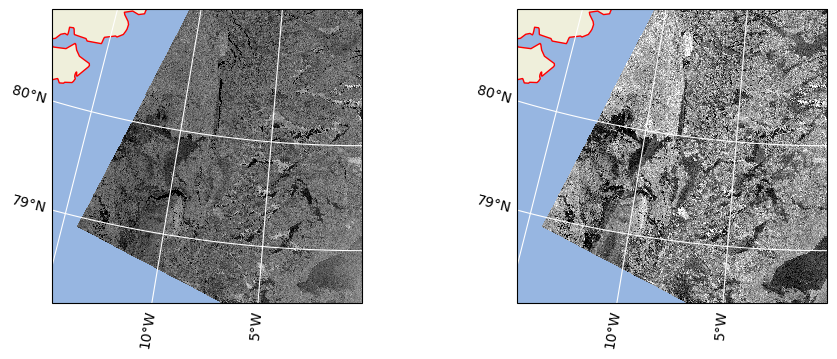

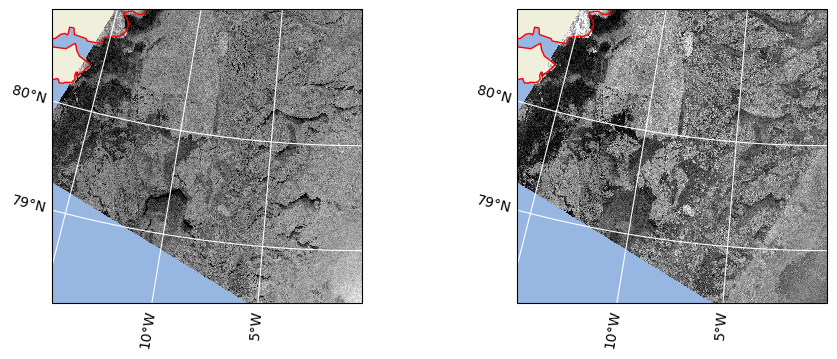

In [16]:
for i,key in enumerate(S1_result_dict.keys()):

    logger.info(f'Processing S1 image {i+1}/{n_imgs}')

    S1_base = S1_result_dict[key]['title']

    # get datestring
    S1_datestring = S1_base.split('_')[4]

    # get date info from S1 name string
    S1_year  = S1_base.split('_')[4][0:4]
    S1_month = S1_base.split('_')[4][4:6]
    S1_day   = S1_base.split('_')[4][6:8]

    # get S1 mode and sensor
    S1_sensor = S1_base[0:3]
    S1_mode   = S1_base.split('_')[1]

    # build url and open data set
    S1_url = f'https://nbstds.met.no/thredds/dodsC/NBS/{S1_sensor}/{S1_year}/{S1_month}/{S1_day}/{S1_mode}/{S1_base}.nc'
    logger.info(f'S1_url: {S1_url}')
    S1_dst = xr.open_dataset(S1_url)

    # load HH
    DN_HH  = S1_dst["Amplitude_HH"][0,::stride,::stride]
    LUT_HH = S1_dst["sigmaNought_HH"][0,::stride,::stride]
    # load HV
    DN_HV  = S1_dst["Amplitude_HV"][0,::stride,::stride]
    LUT_HV = S1_dst["sigmaNought_HV"][0,::stride,::stride]
    # load lat/lon
    lon = S1_dst['lon'][::stride,::stride]
    lat = S1_dst['lat'][::stride,::stride]

    # calibrate HH and HV channel and convert to dB
    logger.info(f'Calibrating HH and HV')
    sigma0_HH    = (DN_HH**2) / (LUT_HH**2)
    sigma0_HV    = (DN_HV**2) / (LUT_HV**2)
    sigma0_HH_dB = 10 * np.log10(sigma0_HH)
    sigma0_HV_dB = 10 * np.log10(sigma0_HV)

    # find min/max percentiles for good visualization
    vmin_HH = np.nanpercentile(sigma0_HH_dB, 0.5)
    vmax_HH = np.nanpercentile(sigma0_HH_dB, 99.5)
    vmin_HV = np.nanpercentile(sigma0_HV_dB, 0.5)
    vmax_HV = np.nanpercentile(sigma0_HV_dB, 99.5)

    # create 8-bit false_color RGB
    new_min = 0
    new_max = 255
    # linear map from sigma0 in dB to new_min and new_max
    HH_scaled = (sigma0_HH_dB - (vmin_HH)) * ((new_max - new_min) / ((vmax_HH) - (vmin_HH))) + new_min
    HV_scaled = (sigma0_HV_dB - (vmin_HV)) * ((new_max - new_min) / ((vmax_HV) - (vmin_HV))) + new_min
    # clip values
    HH_scaled = np.clip(HH_scaled, new_min, new_max)
    HV_scaled = np.clip(HV_scaled, new_min, new_max)
    # stack scaled channels to fals-color RGB
    RGB = np.stack((HV_scaled,HH_scaled,HH_scaled),2)


    # make figure
    logger.info(f'Drawing and saving figure')
    orig_projection = ccrs.PlateCarree()
    target_projection = ccrs.Stereographic(central_longitude=0,central_latitude=60.)

    fig, axes = plt.subplots(1,2, figsize=(10,6), subplot_kw={'projection': target_projection},sharex=True,sharey=True)
    axes = axes.ravel()

    axes[0].set_extent([lon_min_geo_fixed,lon_max_geo_fixed, lat_min_geo_fixed, lat_max_geo_fixed])
    axes[0].add_feature(cartopy.feature.LAND)
    axes[0].add_feature(cartopy.feature.OCEAN)
    gl0 = axes[0].gridlines(color='white',draw_labels=True, y_inline=False)
    axes[0].coastlines(color='red',resolution='10m')
    axes[0].pcolormesh(lon, lat, sigma0_HH_dB, transform=orig_projection, cmap='gray', vmin=vmin_HH, vmax=vmax_HH)
    gl0.top_labels = False
    gl0.right_labels = False
    gl0.xlocator = mticker.FixedLocator(x_grid)
    gl0.ylocator = mticker.FixedLocator(y_grid)

    axes[1].set_extent([lon_min_geo_fixed,lon_max_geo_fixed, lat_min_geo_fixed, lat_max_geo_fixed])
    axes[1].add_feature(cartopy.feature.LAND)
    axes[1].add_feature(cartopy.feature.OCEAN)
    gl1 = axes[1].gridlines(color='white',draw_labels=True, y_inline=False)
    axes[1].coastlines(color='red',resolution='10m')
    axes[1].pcolormesh(lon, lat, sigma0_HV_dB, transform=orig_projection, cmap='gray', vmin=vmin_HV, vmax=vmax_HV)
    gl1.top_labels = False
    gl1.right_labels = False
    gl1.xlocator = mticker.FixedLocator(x_grid)
    gl1.ylocator = mticker.FixedLocator(y_grid)

    plt.subplots_adjust(left = None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)

    # build figure output path
    output_dir = Path('figures')
    output_dir.mkdir(exist_ok=True)
    output_path = output_dir / f'{S1_datestring}.png'

    # save figure
    plt.savefig(output_path, dpi=300)

    # avoid opening many figures if the search got many hits
    if i>1:
        plt.close()

## Set parameters for S2 overlap search
---
You can now search for spatially overlapping S2 data that were acquired close in time. Set the parameters for your _sentinelAPI_ query to search for overlapping S2 images. Adjust the maximum time difference between the image acquisitions (_overlap_interval_hours_) and the min/max cloud cover for the optical imagery for the requirements of your project. The search below uses the same ROI as the previous search for S1 data, to avoid finding many overlapping images over Greenland (the study focuses on sea ice). You can search for any overlap by setting the *S2_area* using the footprint of each S1 scene inside the loop.

In [17]:
# maximum time difference between S1 and S2 acquisition (in hours)
overlap_interval_hours = 8

# min/max cloud cover for S2 overlap
min_cloud = 0
max_cloud = 30

# search area
S2_area = geojson_to_wkt(read_geojson(json_file))

# area relation for S2
S2_area_relation = 'Intersects'

# calculate datetime.timedelta from overlap_interval
timedelta = datetime.timedelta(hours=overlap_interval_hours)

## Loop over all S1 images and search for S2 overlap 
---

In [18]:
for i,key in enumerate(S1_result_dict.keys()):

    logger.info(f'Searching for overlap for S1 image {i+1}/{n_imgs}')

    # get current S1 product
    p = S1_result_dict[key]

    # get S1 timestamp
    S1_time = p['beginposition']

    # define starttime and endtime for S2 search based on timedelta
    S2_starttime = S1_time - timedelta
    S2_endtime   = S1_time + timedelta

    logger.debug(f'S1_base:      {p["title"]}')
    logger.debug(f'S1_time:      {S1_time}')
    logger.debug(f'S2_starttime: {S2_starttime}')
    logger.debug(f'S2_endtime:   {S2_endtime}')
    logger.debug(f'minimum cloud cover: {min_cloud}, maximum cloud cover: {max_cloud}')

    # search for S2 data
    S2_result_dict = Sentinelapi.query(
        area = S2_area,
        date = (S2_starttime, S2_endtime),
        area_relation = S2_area_relation,
        platformname = "Sentinel-2",
        processinglevel = "Level-1C",
        cloudcoverpercentage = (min_cloud, max_cloud)
    )

    # get number of hits
    S2_n_imgs = len(S2_result_dict.keys())
    logger.info(f'Found {S2_n_imgs} overlapping S2 images for current S1 scene')

    # initialize list of found S2 images
    S2_img_list = []

    # loop over search results and append to S2_img_list
    for i,key in enumerate(S2_result_dict.keys()):
        logger.info(f"Image {i+1}/{S2_n_imgs}: {S2_result_dict[key]['title']}")
        S2_img_list.append(S2_result_dict[key]['title'])

    # write search result name strings to txt file
    search_result_dir = Path('search_results/S2_overlap')
    search_result_dir.mkdir(exist_ok=True, parents=True)
    search_result_file = search_result_dir / f"{p['title']}_S2_overlap_results.txt"

    logger.debug(f'search_result_dir: {search_result_dir}')
    logger.debug(f'search_result_file: {search_result_file}')

    with open(search_result_file, 'w') as f:
        f.write('\n'.join(S2_img_list))

2023-02-09 13:22:22.748 | INFO     | __main__:<module>:3 - Searching for overlap for S1 image 1/13
2023-02-09 13:22:23.296 | INFO     | __main__:<module>:33 - Found 0 overlapping S2 images for current S1 scene
2023-02-09 13:22:23.305 | INFO     | __main__:<module>:3 - Searching for overlap for S1 image 2/13
2023-02-09 13:22:23.603 | INFO     | __main__:<module>:33 - Found 4 overlapping S2 images for current S1 scene
2023-02-09 13:22:23.604 | INFO     | __main__:<module>:40 - Image 1/4: S2A_MSIL1C_20220418T150801_N0400_R025_T28XEN_20220418T171732
2023-02-09 13:22:23.604 | INFO     | __main__:<module>:40 - Image 2/4: S2A_MSIL1C_20220418T150801_N0400_R025_T29XMH_20220418T171732
2023-02-09 13:22:23.605 | INFO     | __main__:<module>:40 - Image 3/4: S2B_MSIL1C_20220418T141739_N0400_R096_T29XMH_20220418T145509
2023-02-09 13:22:23.605 | INFO     | __main__:<module>:40 - Image 4/4: S2B_MSIL1C_20220418T141739_N0400_R096_T28XEN_20220418T145509
2023-02-09 13:22:23.641 | INFO     | __main__:<modul

## Visualize S1 and S2 combined
---
Show an example of overlapping S1 and S2 imagery. Select one of the S1 images from the previous search (*S1_base*) and the *m-th* hit from the overlapping S2 images.

In [19]:
# select S1 image
S1_base = 'S1A_EW_GRDM_1SDH_20220408T074526_20220408T074630_042679_05179F_7E4F'

# define path to file with S2 overlaps
S2_overlap_file = f'search_results/S2_overlap/{S1_base}_S2_overlap_results.txt'

# get m-th overlapping image
m = 1
S2_base = linecache.getline(S2_overlap_file, m).strip('\n')

# get date info and sensor from S2 name string
S2_year   = S2_base.split('_')[2][0:4]
S2_month  = S2_base.split('_')[2][4:6]
S2_day    = S2_base.split('_')[2][6:8]
S2_sensor = S2_base[0:3]

# get date info, mode, and sensor from S1 name string
S1_year   = S1_base.split('_')[4][0:4]
S1_month  = S1_base.split('_')[4][4:6]
S1_day    = S1_base.split('_')[4][6:8]
S1_sensor = S1_base[0:3]
S1_mode   = S1_base.split('_')[1]

# build urls and and open data sets
S1_url = f'https://nbstds.met.no/thredds/dodsC/NBS/{S1_sensor}/{S1_year}/{S1_month}/{S1_day}/{S1_mode}/{S1_base}.nc'
S2_url = f'https://nbstds.met.no/thredds/dodsC/NBS/{S2_sensor}/{S2_year}/{S2_month}/{S2_day}/{S2_base}.nc'

S1_dst = xr.open_dataset(S1_url)
S2_dst = xr.open_dataset(S2_url)

## Select bands
---
Select RGB channels (B4, B3, B2) from S2, and  HH and HV channel from S1:

In [20]:
S2_stride = 5
B2  = S2_dst["B2"][0,::S2_stride,::S2_stride]
B3  = S2_dst["B3"][0,::S2_stride,::S2_stride]
B4  = S2_dst["B4"][0,::S2_stride,::S2_stride]
S2_lon = S2_dst['lon'][::S2_stride,::S2_stride]
S2_lat = S2_dst['lat'][::S2_stride,::S2_stride]

S1_stride = 5
DN_HH  = S1_dst["Amplitude_HH"][0,::S1_stride,::S1_stride]
LUT_HH = S1_dst["sigmaNought_HH"][0,::S1_stride,::S1_stride]
DN_HV  = S1_dst["Amplitude_HV"][0,::S1_stride,::S1_stride]
LUT_HV = S1_dst["sigmaNought_HV"][0,::S1_stride,::S1_stride]
S1_lon = S1_dst['lon'][::S1_stride,::S1_stride]
S1_lat = S1_dst['lat'][::S1_stride,::S1_stride]

## Get S2 footprint
---
Use the S2 footprint to set the map extent later on.

In [21]:
# get image footprint
S2_lon_min_geo = np.min(S2_lon)
S2_lon_max_geo = np.max(S2_lon)
S2_lat_min_geo = np.min(S2_lat)
S2_lat_max_geo = np.max(S2_lat)

## Calibrate data and get percentiles for visualization
---

In [22]:
sigma0_HH    = (DN_HH**2) / (LUT_HH**2)
sigma0_HV    = (DN_HV**2) / (LUT_HV**2)
sigma0_HH_dB = 10 * np.log10(sigma0_HH)
sigma0_HV_dB = 10 * np.log10(sigma0_HV)

In [23]:
vmin_B2 = np.nanpercentile(B2,0.5)
vmax_B2 = np.nanpercentile(B2,99.5)
vmin_B3 = np.nanpercentile(B3,0.5)
vmax_B3 = np.nanpercentile(B3,99.5)
vmin_B4 = np.nanpercentile(B4,0.5)
vmax_B4 = np.nanpercentile(B4,99.5)

vmin_HH = np.nanpercentile(sigma0_HH_dB, 0.5)
vmax_HH = np.nanpercentile(sigma0_HH_dB, 99.5)
vmin_HV = np.nanpercentile(sigma0_HV_dB, 0.5)
vmax_HV = np.nanpercentile(sigma0_HV_dB, 99.5)

## Visualize together on map
---
Visualize the data on a map. The map extent is defined by the smaller footprint to see more details:

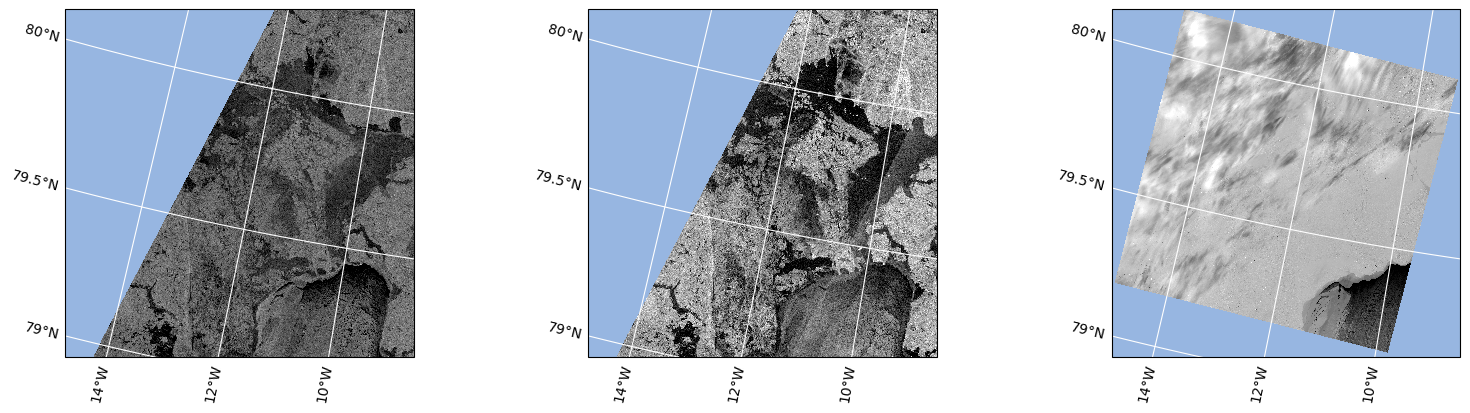

In [24]:
orig_projection = ccrs.PlateCarree()
target_projection = ccrs.Stereographic(central_longitude=0,central_latitude=60.)

fig, axes = plt.subplots(1,3, figsize=(18,6), subplot_kw={'projection': target_projection})
axes = axes.ravel()

axes[0].set_extent([S2_lon_min_geo,S2_lon_max_geo, S2_lat_min_geo, S2_lat_max_geo])
axes[0].add_feature(cartopy.feature.LAND)
axes[0].add_feature(cartopy.feature.OCEAN)
gl0 = axes[0].gridlines(color='white',draw_labels=True, y_inline=False)
axes[0].coastlines(color='red',resolution='10m')
axes[0].pcolormesh(S1_lon, S1_lat, sigma0_HH_dB, transform=orig_projection, cmap='gray', vmin=vmin_HH, vmax=vmax_HH)
gl0.top_labels = False
gl0.right_labels = False
gl0.xlocator = mticker.FixedLocator([-14, -12, -10])
gl0.ylocator = mticker.FixedLocator([79, 79.5, 80])

axes[1].set_extent([S2_lon_min_geo,S2_lon_max_geo, S2_lat_min_geo, S2_lat_max_geo])
axes[1].add_feature(cartopy.feature.LAND)
axes[1].add_feature(cartopy.feature.OCEAN)
gl1 = axes[1].gridlines(color='white',draw_labels=True, y_inline=False)
axes[1].coastlines(color='red',resolution='10m')
axes[1].pcolormesh(S1_lon, S1_lat, sigma0_HV_dB, transform=orig_projection, cmap='gray', vmin=vmin_HV, vmax=vmax_HV)
gl1.top_labels = False
gl1.right_labels = False
gl1.xlocator = mticker.FixedLocator([-14, -12, -10])
gl1.ylocator = mticker.FixedLocator([79, 79.5, 80])


axes[2].set_extent([S2_lon_min_geo,S2_lon_max_geo, S2_lat_min_geo, S2_lat_max_geo])
axes[2].add_feature(cartopy.feature.LAND)
axes[2].add_feature(cartopy.feature.OCEAN)
gl2 = axes[2].gridlines(color='white',draw_labels=True, y_inline=False)
axes[2].coastlines(color='red',resolution='10m')
axes[2].pcolormesh(S2_lon, S2_lat, B4, transform=orig_projection, cmap='gray', vmin=vmin_B4, vmax=vmax_B4)
gl2.top_labels = False
gl2.right_labels = False
gl2.xlocator = mticker.FixedLocator([-14, -12, -10])
gl2.ylocator = mticker.FixedLocator([79, 79.5, 80])

plt.subplots_adjust(left = None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)